In [1]:
from csv import QUOTE_NONNUMERIC

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

In [4]:
%matplotlib inline

In [5]:
plt.rcParams['figure.figsize'] = 16, 9

In [6]:
collections = [
    "agora",
    "bigg",
    "carveme",
    "ebrahim",
    "kbase",
    "metagem",
    "optflux",
    "path"
]

In [7]:
files = [
    "../data/agora.csv.gz",
    "../data/bigg.csv.gz",
    "../data/carveme.csv.gz",
    "../data/ebrahim.csv.gz",
    "../data/kbase.csv.gz",
    "../data/metagem.csv.gz",
    "../data/optflux.csv.gz",
    "../data/path.csv.gz"
]

In [8]:
colors = [
  "#A6A9AA",
  "#000000",
  "#A3D2E2",
  "#3E7CBC",
  "#EDA85F",
  "#F29FA9",
  "#CD2028",
  "#737878"
]

## Extract

In [9]:
bucket = []
for filename, collection in zip(files, collections):
    tmp = pd.read_csv(filename)
    tmp["collection"] = collection
    bucket.append(tmp)
df = pd.concat(bucket, ignore_index=True)

In [10]:
df.shape

(2170588, 11)

In [11]:
df.head()

,test,title,section,metric,numeric,model,time,score,weight,status,collection
0,test_absolute_extreme_coefficient_ratio,Ratio Min/Max Non-Zero Coefficients,matrix,0.0,5762.29,Eggerthella_sp_1_3_56FAA,0.016577,NaN,NaN,passed,agora
1,test_biomass_consistency,Biomass Consistency,test_biomass,NaN,NaN,Eggerthella_sp_1_3_56FAA,0.000461,NaN,NaN,failed,agora
2,test_biomass_consistency,Biomass Consistency,test_biomass,NaN,NaN,Eggerthella_sp_1_3_56FAA,0.000430,NaN,NaN,failed,agora
3,test_biomass_default_production,Biomass Production In Default Medium,test_biomass,0.0,59.9503,Eggerthella_sp_1_3_56FAA,0.002195,NaN,NaN,passed,agora
4,test_biomass_default_production,Biomass Production In Default Medium,test_biomass,0.0,59.9503,Eggerthella_sp_1_3_56FAA,0.133996,NaN,NaN,passed,agora


## Transform

### Filter _E. coli_ Strain Models

In [12]:
taxonomy = pd.read_csv("../data/bigg_taxonomy.csv.gz")

In [13]:
taxonomy[taxonomy["strain"].isnull()] = ""

In [14]:
strains = taxonomy.loc[taxonomy["strain"].str.startswith("Escherichia coli"), "model"]

Exclude desired models.

In [15]:
strains = strains[~strains.isin(["iML1515", "iJO1366", "iAF1260", "iJR904"])]

In [16]:
df = df.loc[
    ~((df["collection"] == "bigg") & df["model"].isin(strains)), :
]

### Filter Unsuitable Test Cases

Exclude the biomass section since it is not universally applicable and may contain multiple reactions per model.

In [17]:
df = df.loc[~df["section"].isin([
    "test_biomass",
    "basic_info"
]), :]

We further exclude tests related to the biomass but from different sections.

In [18]:
df = df.loc[~df["test"].isin([
    "test_biomass_open_production",
    "test_essential_precursors_not_in_biomass",
    "test_gam_in_biomass"
]), :]

We further exclude tests that are not properly normalized to the range of 0-1.

In [19]:
df = df.loc[~df["test"].isin([
    "test_metabolic_coverage",
]), :]

We further invalidate metric results where the numeric test result is missing.

In [20]:
df.loc[df["numeric"].isnull(), "metric"] = float("nan")

### Pivot Table

Each model from each collection is one observation (row) and each test case constitutes one variable or category (column) measuring model performance.

In [21]:
observations = df.set_index(["collection", "model", "test"])

Check for duplicates which will prevent unstacking.

In [22]:
observations[observations.index.duplicated(keep=False)].sort_index()

,,,title,section,metric,numeric,time,score,weight,status
collection,model,test,,,,,,,,


Confirm that `metric` values are only between zero and one.

In [23]:
observations.describe()

,metric,time,score,weight
count,1.626524e+06,1.916940e+06,1.203059e+06,1.203660e+06
mean,7.029634e-01,9.882051e-01,1.278281e-01,1.024691e+00
std,4.305313e-01,8.067743e+00,3.215693e-01,2.208463e-01
min,0.000000e+00,6.413460e-05,0.000000e+00,1.000000e+00
25%,1.846966e-01,5.743504e-04,0.000000e+00,1.000000e+00
50%,1.000000e+00,1.017332e-03,0.000000e+00,1.000000e+00
75%,1.000000e+00,3.118515e-03,0.000000e+00,1.000000e+00
max,1.000000e+00,2.160795e+03,1.000000e+00,3.000000e+00


In [24]:
observations = observations.loc[:, ["metric"]].unstack()
observations.head()

metric  \
test                                             test_absolute_extreme_coefficient_ratio   
collection model                                                                           
agora      Abiotrophia_defectiva_ATCC_49176                                          0.0   
           Achromobacter_xylosoxidans_A8                                             0.0   
           Achromobacter_xylosoxidans_NBRC_15126                                     0.0   
           Acidaminococcus_fermentans_DSM_20731                                      0.0   
           Acidaminococcus_intestini_RyC_MR95                                        0.0   

                                                                                     \
test                                             test_biomass_specific_sbo_presence   
collection model                                                                      
agora      Abiotrophia_defectiva_ATCC_49176                                     1.0   
           Achromobacter_xylosoxidans_A8                                        1.0   
           Achromobacter_xylosoxidans_NBRC_15126                                1.0   
           Acidaminococcus_fermentans_DSM_20731                                 1.0   
           Acidaminococcus_intestini_RyC_MR95                                   1.0   

                                                                         \
test                                             test_blocked_reactions   
collection model                                                          
agora      Abiotrophia_defectiva_ATCC_49176                    0.285182   
           Achromobacter_xylosoxidans_A8                       0.356715   
           Achromobacter_xylosoxidans_NBRC_15126               0.288530   
           Acidaminococcus_fermentans_DSM_20731                0.347550   
           Acidaminococcus_intestini_RyC_MR95                  0.302697   

                                                                          \
test                                             test_degrees_of_freedom   
collection model                                                           
agora      Abiotrophia_defectiva_ATCC_49176                     0.176142   
           Achromobacter_xylosoxidans_A8                        0.227818   
           Achromobacter_xylosoxidans_NBRC_15126                0.234170   
           Acidaminococcus_fermentans_DSM_20731                 0.168784   
           Acidaminococcus_intestini_RyC_MR95                   0.143856   

                                                                                    \
test                                             test_demand_specific_sbo_presence   
collection model                                                                     
agora      Abiotrophia_defectiva_ATCC_49176                                    1.0   
           Achromobacter_xylosoxidans_A8                                       1.0   
           Achromobacter_xylosoxidans_NBRC_15126                               1.0   
           Acidaminococcus_fermentans_DSM_20731                                1.0   
           Acidaminococcus_intestini_RyC_MR95                                  1.0   

                                                                                              \
test                                             test_detect_energy_generating_cycles-MNXM10   
collection model                                                                               
agora      Abiotrophia_defectiva_ATCC_49176                                              NaN   
           Achromobacter_xylosoxidans_A8                                                 NaN   
           Achromobacter_xylosoxidans_NBRC_15126                                         NaN   
           Acidaminococcus_fermentans_DSM_20731                                          NaN   
           Acidaminococcus_intestini_RyC_MR95                                

In [25]:
observations.shape

(14860, 129)

### Handle Missing Values

In [26]:
observations.isna().sum(axis=0).sort_values(ascending=False)

        test                                                    
metric  test_detect_energy_generating_cycles-MNXM3                  14860
        test_detect_energy_generating_cycles-MNXM7517               14860
        test_detect_energy_generating_cycles-MNXM6                  14860
        test_detect_energy_generating_cycles-MNXM558                14860
        test_detect_energy_generating_cycles-MNXM51                 14860
        test_detect_energy_generating_cycles-MNXM423                14860
        test_detect_energy_generating_cycles-MNXM38                 14860
        test_detect_energy_generating_cycles-MNXM89557              14860
        test_detect_energy_generating_cycles-MNXM223                14860
        test_detect_energy_generating_cycles-MNXM21                 14860
        test_detect_energy_generating_cycles-MNXM208                14860
        test_detect_energy_generating_cycles-MNXM191                14860
        test_detect_energy_generating_cycles-MN

We set the missing values equivalent to being completely wrong, i.e., metric = 1.

In [27]:
observations[observations.isna()] = 1.0

### Export

In [28]:
observations.columns = observations.columns.droplevel(0)

In [29]:
observations.reset_index(level=["collection", "model"]).to_csv("../data/clustering_features.csv.gz", index=False,
                    quoting=QUOTE_NONNUMERIC, compression="gzip")

## Dimension Reduction

### PCA

In [30]:
pca = PCA(whiten=True).fit_transform(observations)

In [31]:
x = []
y = []
lbl = []
for label in collections:
    mask = observations.index.get_level_values("collection") == label
    x.extend(pca[mask, 0])
    y.extend(pca[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/metric_pca.csv.gz", index=False,
                                                         quoting=QUOTE_NONNUMERIC, compression="gzip")

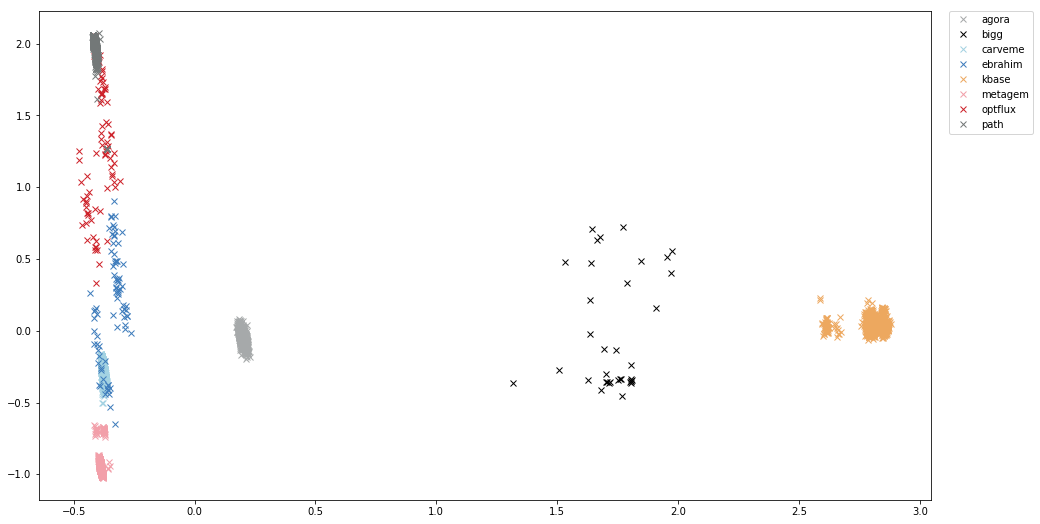

In [32]:
for label, color in zip(collections, colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(pca[mask, 0], pca[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()

### t-SNE

In [33]:
tsne = TSNE(n_components=2).fit_transform(observations)

In [34]:
x = []
y = []
lbl = []
for label in collections:
    mask = observations.index.get_level_values("collection") == label
    x.extend(tsne[mask, 0])
    y.extend(tsne[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/metric_tsne.csv.gz", index=False,
                                                         quoting=QUOTE_NONNUMERIC, compression="gzip")

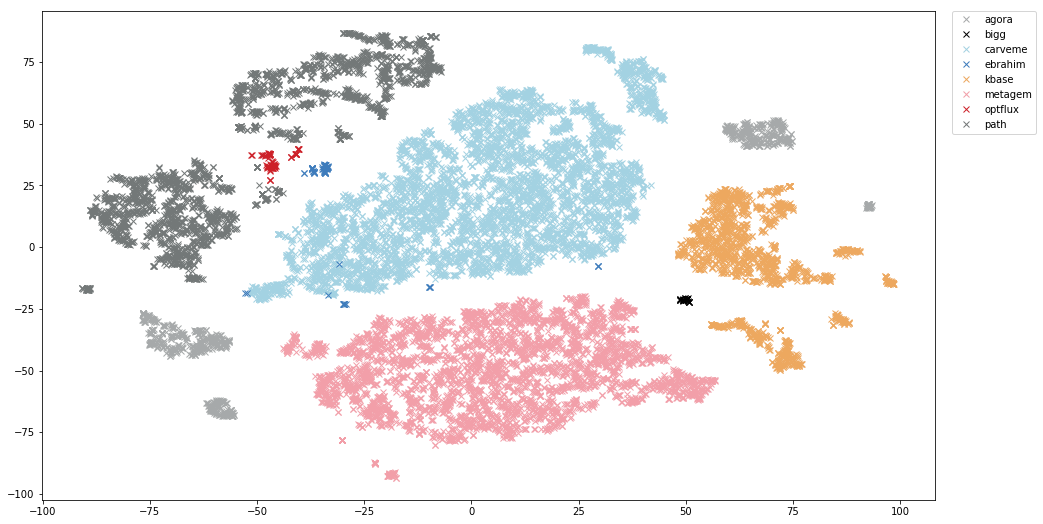

In [35]:
for label, color in zip(collections, colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(tsne[mask, 0], tsne[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()

### UMAP

In [36]:
umap = UMAP(n_components=2).fit_transform(observations)

In [37]:
x = []
y = []
lbl = []
for label in collections:
    mask = observations.index.get_level_values("collection") == label
    x.extend(umap[mask, 0])
    y.extend(umap[mask, 1])
    lbl.extend([label] * mask.sum())
pd.DataFrame({"x": x, "y": y, "collection": lbl}).to_csv("../data/metric_umap.csv.gz", index=False,
                                                         quoting=QUOTE_NONNUMERIC, compression="gzip")

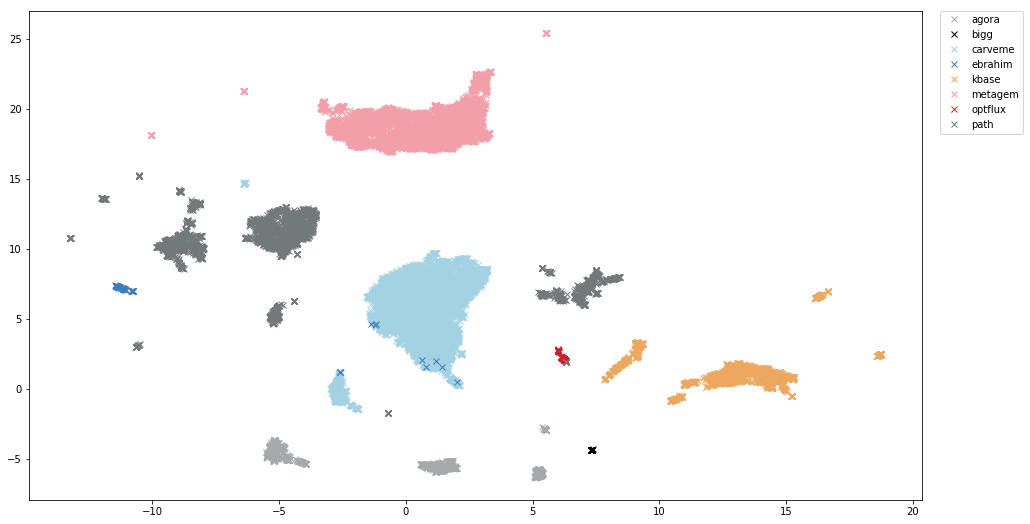

In [38]:
for label, color in zip(collections, colors):
    mask = observations.index.get_level_values("collection") == label
    plt.plot(umap[mask, 0], umap[mask, 1], "x", color=color, label=label)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.0)
plt.show()